In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers

from tqdm import tqdm

In [0]:
os.environ["KERAS_BACKEND"] = "tensorflow"

In [0]:
mnist_data = keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist_data.load_data()

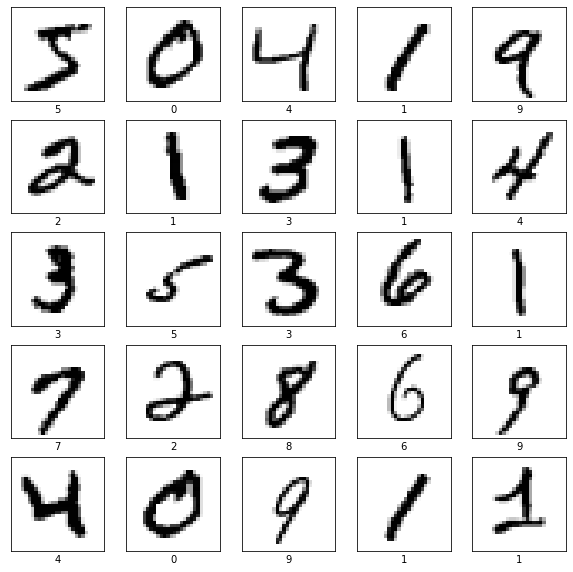

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [0]:
# The dimension of random noise vector.
rand_noise_v_dim = 100
np.random.seed(10)

In [0]:
def get_optimizer():
    return Adam(lr=0.0002, beta_1=0.5)

In [0]:
def create_generator(optimizer):
    generator = Sequential()
    generator.add(Dense(
        256, # units
        input_dim=rand_noise_v_dim, 
        kernel_initializer=initializers.RandomNormal(stddev=0.02))
    )
    
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(512))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(1024))
    generator.add(LeakyReLU(0.2))

    generator.add(Dense(784, activation='tanh'))
    generator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return generator

In [0]:
def create_discriminator(optimizer):
    discriminator = Sequential()
    discriminator.add(Dense(
        1024, 
        input_dim=784, 
        kernel_initializer=initializers.RandomNormal(stddev=0.02)))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(512))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(256))
    discriminator.add(LeakyReLU(0.2))
    discriminator.add(Dropout(0.3))

    discriminator.add(Dense(
        1,
        activation='sigmoid')
    )
    discriminator.compile(loss='binary_crossentropy', optimizer=optimizer)
    return discriminator

In [0]:
def get_gan_network(discriminator, random_dim, generator, optimizer):
    # We initially set trainable to False since we only want to train either the 
    # generator or discriminator at a time
    discriminator.trainable = False
    # gan input (noise) will be 100-dimensional vectors
    gan_input = Input(shape=(random_dim,))
    # the output of the generator (an image)
    x = generator(gan_input)
    # get the output of the discriminator (probability if the image is real or not)
    gan_output = discriminator(x)
    gan = Model(inputs=gan_input, outputs=gan_output)
    gan.compile(loss='binary_crossentropy', optimizer=optimizer)
    return gan

In [0]:
def plot_generated_images(epoch, generator, title="", examples=10, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, rand_noise_v_dim])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(examples, 28, 28)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='gray_r')
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()

In [0]:
def train(epochs=1, batch_size=128):    
    (x_train, y_train), (x_test, y_test) = mnist_data.load_data()
    x_train = (x_train.astype(np.float32) - 127.5)/127.5
    x_train = x_train.reshape(60000, 784)
    # Split the training data into batches of size 128
    batch_count = x_train.shape[0] / batch_size
    # Build our GAN netowrk
    adam = get_optimizer()
    generator = create_generator(adam)
    discriminator = create_discriminator(adam)
    gan = get_gan_network(discriminator, rand_noise_v_dim, generator, adam)

    for e in range(1, epochs+1):
        for _ in tqdm(range(int(batch_count))):
            # Get a random set of input noise and images
            noise = np.random.normal(0, 1, size=[batch_size, rand_noise_v_dim])
            image_batch = x_train[np.random.randint(0, x_train.shape[0], size=batch_size)]

            # Generate fake MNIST images
            generated_images = generator.predict(noise)
            X = np.concatenate([image_batch, generated_images])

            # Labels for generated and real data
            y_dis = np.zeros(2*batch_size)
            # One-sided label smoothing
            y_dis[:batch_size] = 0.9

            # Train discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_dis)

            # Train generator
            noise = np.random.normal(0, 1, size=[batch_size, rand_noise_v_dim])
            y_gen = np.ones(batch_size)
            discriminator.trainable = False
            gan.train_on_batch(noise, y_gen)

        if e == 1 or e % 20 == 0:
            plot_generated_images(e, generator, title='-'*15 + 'Epoch %d' % e + '-'*15)


100%|██████████| 468/468 [01:03<00:00,  7.37it/s]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  if sys.path[0] == '':
100%|██████████| 468/468 [01:07<00:00,  6.95it/s]


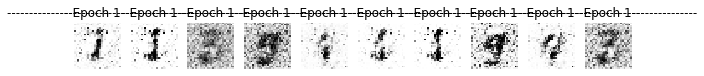

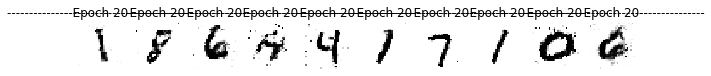

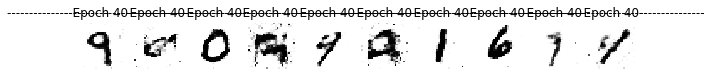

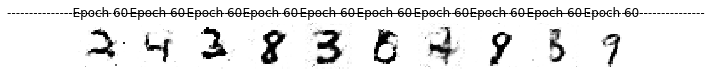

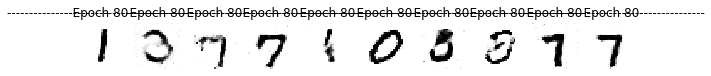

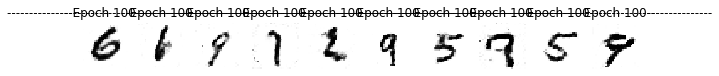

In [13]:
train(100, 128)